This script takes image and mask chips from various cities and loads pretrained U-Net with a ResNet34 encoder model from Segmentation models library and trains it on those chips.

In [ ]:
#install packages
!pip install patchify
!pip install segmentation_models

In [ ]:
import os
import numpy as np

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


get the data from drive

In [ ]:
dir =  #location of main folder

def get_chips_from_drive(city, chips_folder_name):
  location_image_chips = os.path.join(dir, city, chips_folder_name, "image_chips_balanced.npy")
  loaded_image = np.load(location_image_chips)
  location_image_pugs = os.path.join(dir, city, chips_folder_name, "parks_chips_balanced.npy")
  loaded_pugs = np.load(location_image_pugs)
  return loaded_image, loaded_pugs

In [ ]:
chips_folder_name = "3_chips_10_r_nir_ndvi"

image_array_amsterdam, park_array_amsterdam = get_chips_from_drive("Amsterdam", chips_folder_name)
image_array_buffalo, park_array_buffalo = get_chips_from_drive("Buffalo", chips_folder_name)
image_array_dhaka, park_array_dhaka = get_chips_from_drive("Dhaka", chips_folder_name)
image_array_dublin, park_array_dublin = get_chips_from_drive("Dublin", chips_folder_name)
image_array_ghent, park_array_ghent = get_chips_from_drive("Ghent", chips_folder_name)
image_array_london, park_array_london = get_chips_from_drive("London", chips_folder_name)
image_array_manchester, park_array_manchester = get_chips_from_drive("Manchester", chips_folder_name)
image_array_philadelphia, park_array_philadelphia = get_chips_from_drive("Philadelphia", chips_folder_name)
image_array_seattle, park_array_seattle = get_chips_from_drive("Seattle", chips_folder_name)
image_array_vancouver, park_array_vancouver = get_chips_from_drive("Vancouver", chips_folder_name)

In [ ]:
print("amsterdam image - ", image_array_amsterdam.shape, "park - ", park_array_amsterdam.shape)
print("buffalo image - ", image_array_buffalo.shape, "park - ", park_array_buffalo.shape)
print("dhaka image - ", image_array_dhaka.shape, "park - ", park_array_dhaka.shape )
print("dublin image - ", image_array_dublin.shape, "park - ", park_array_dublin.shape )
print("ghent image - ", image_array_ghent.shape, "park - ", park_array_ghent.shape )
print("london image - ", image_array_london.shape, "park - ", park_array_london.shape)
print("manchester image - ", image_array_manchester.shape, "park - ", park_array_manchester.shape)
print("philadelphia image - ", image_array_philadelphia.shape, "park - ", park_array_philadelphia.shape)
print("seattle image - ", image_array_seattle.shape, "park - ", park_array_seattle.shape)
print("vancouver image - ", image_array_vancouver.shape, "park - ", park_array_vancouver.shape)

amsterdam image -  (723, 256, 256, 3) park -  (723, 256, 256, 1)
buffalo image -  (604, 256, 256, 3) park -  (604, 256, 256, 1)
dhaka image -  (34, 256, 256, 3) park -  (34, 256, 256, 1)
dublin image -  (712, 256, 256, 3) park -  (712, 256, 256, 1)
ghent image -  (435, 256, 256, 3) park -  (435, 256, 256, 1)
london image -  (1060, 256, 256, 3) park -  (1060, 256, 256, 1)
manchester image -  (1100, 256, 256, 3) park -  (1100, 256, 256, 1)
philadelphia image -  (1107, 256, 256, 3) park -  (1107, 256, 256, 1)
seattle image -  (812, 256, 256, 3) park -  (812, 256, 256, 1)
vancouver image -  (429, 256, 256, 3) park -  (429, 256, 256, 1)


merge into one numpy array

In [ ]:
image_dataset = np.concatenate((image_array_amsterdam, image_array_buffalo, image_array_dhaka, image_array_dublin, image_array_ghent, image_array_london,
                                image_array_manchester,image_array_philadelphia,  image_array_seattle, image_array_vancouver), axis=0)

park_dataset = np.concatenate((park_array_amsterdam, park_array_buffalo, park_array_dhaka, park_array_dublin, park_array_ghent, park_array_london,
                               park_array_manchester,park_array_philadelphia,  park_array_seattle, park_array_vancouver), axis=0)

In [ ]:
del image_array_amsterdam, image_array_buffalo, image_array_dhaka, image_array_dublin, image_array_ghent, image_array_london, image_array_manchester,image_array_philadelphia,  image_array_seattle, image_array_vancouver
del park_array_amsterdam, park_array_buffalo, park_array_dhaka, park_array_dublin, park_array_ghent, park_array_london, park_array_manchester,park_array_philadelphia, park_array_seattle, park_array_vancouver

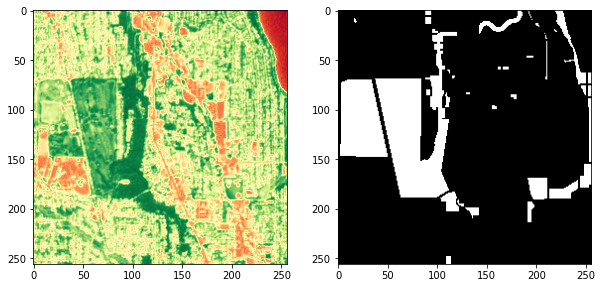

In [ ]:
# check whether the cropped images match

import random
import matplotlib.pyplot as plt

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,2], cmap='RdYlGn')

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
image_dataset[image_dataset > 1] = 1  # replace some wired values like 1.000001 with 1
print("Image data shape is: ", image_dataset.shape)
print("Park data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))
print("Number of park pixels: ", np.count_nonzero(park_dataset == 1))
print("Number of no-park pixels: ", np.count_nonzero(park_dataset == 0))
print("Percentage of park: ", np.count_nonzero(park_dataset == 1)/(np.count_nonzero(park_dataset == 1)+np.count_nonzero(park_dataset == 0)))

Image data shape is:  (7016, 256, 256, 3)
Park data shape is:  (7016, 256, 256, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
Number of park pixels:  87309749
Number of no-park pixels:  372490827
Percentage of park:  0.18988612358763118


prepering data for modelling

In [ ]:
#import cv2

In [ ]:
from sklearn.model_selection import train_test_split

X_train_old, X_test_old, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.2, random_state = 42)

In [ ]:
print(X_train_old.shape)
print(y_train.shape)

(5612, 256, 256, 3)
(5612, 256, 256, 1)


model building with a backbone

In [ ]:
# preprocess input to fit model architecture
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow as tf
from keras.layers import Input, Conv2D
from keras.models import Model

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE) # get the preprocessing function
X_train = preprocess_input(X_train_old)
X_test = preprocess_input(X_test_old)
print(X_train.shape, X_test.shape)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
(5612, 256, 256, 3) (1404, 256, 256, 3)


In [ ]:
del X_train_old, X_test_old, image_dataset, park_dataset

In [ ]:
# turn park_dataset into categorical
from tensorflow.keras.utils import to_categorical

# y_train
train_masks_cat = to_categorical(y_train, num_classes=2)
y_train = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))

# y_test
test_masks_cat = to_categorical(y_test, num_classes=2)
y_test = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))

print(y_train.shape, y_test.shape)

(5612, 256, 256, 2) (1404, 256, 256, 2)


data augumentation

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='reflect',
                         preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) 

In [ ]:
# set the batch size of image generator
batch_size= 8

# image generator (X_train and X_test)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) 

# mask generator (y_train and y_test)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (5612, 256, 256, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5612, 256, 256, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 chann

In [ ]:
# put image generator and mask generator together
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)

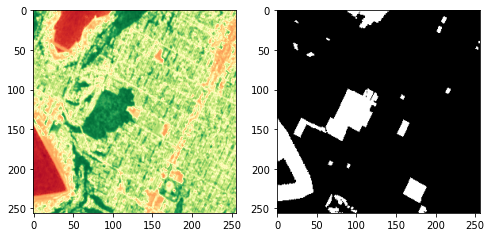

In [ ]:
#check the augumentation 
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(8, 4))
    image = x[i]
    mask = y[i]
    plt.subplot(121)
    plt.imshow(image[:,:,2], cmap='RdYlGn')

    
    plt.subplot(122)
    plt.imshow(mask[:,:,1], cmap = 'gray')
    plt.show()

model set up 

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# build model (U-Net with resnet34 backbone, pretrained on imagenet)
sm.set_framework('tf.keras')
sm.framework()

#define model
model = sm.Unet(backbone_name = 'resnet34', encoder_weights='imagenet', classes= 2, activation = 'sigmoid') 

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=Adam(learning_rate = 1e-4), loss = sm.losses.binary_focal_dice_loss, 
               metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

# #model.summary()

85532672/85521592 [==============================] - 5s 0us/step


In [ ]:
# set hyperparameters - data augumentation
batch_size = 16
steps_per_epoch = len(X_train)//batch_size  # for generator, you need to specify the steps if using generator
validation_steps = len(X_test)//batch_size  # for generator
print(steps_per_epoch, validation_steps)

350 87


In [ ]:
# model training (with data augmentation)
history = model.fit(train_generator, batch_size=16, epochs=40,  steps_per_epoch = steps_per_epoch,
                     validation_steps = validation_steps, verbose=1, validation_data = validation_generator)

Epoch 1/40
350/350 [==============================] - 95s 219ms/step - loss: 0.4532 - iou_score: 0.6297 - f1-score: 0.7468 - precision: 0.7506 - recall: 0.8950 - accuracy: 0.8244 - val_loss: 0.5990 - val_iou_score: 0.4147 - val_f1-score: 0.4540 - val_precision: 0.8281 - val_recall: 0.8067 - val_accuracy: 0.8283
Epoch 2/40
350/350 [==============================] - 75s 215ms/step - loss: 0.3264 - iou_score: 0.7011 - f1-score: 0.8108 - precision: 0.8753 - recall: 0.8875 - accuracy: 0.8808 - val_loss: 0.5623 - val_iou_score: 0.4613 - val_f1-score: 0.5432 - val_precision: 0.8061 - val_recall: 0.8143 - val_accuracy: 0.8163
Epoch 3/40
350/350 [==============================] - 76s 215ms/step - loss: 0.2880 - iou_score: 0.7225 - f1-score: 0.8270 - precision: 0.8936 - recall: 0.8942 - accuracy: 0.8942 - val_loss: 0.4513 - val_iou_score: 0.5904 - val_f1-score: 0.6995 - val_precision: 0.8662 - val_recall: 0.8587 - val_accuracy: 0.8680
Epoch 4/40
350/350 [==============================] - 75s 215

In [ ]:
#save model

from tensorflow import keras
model.save('location to save the model') #save model to drive

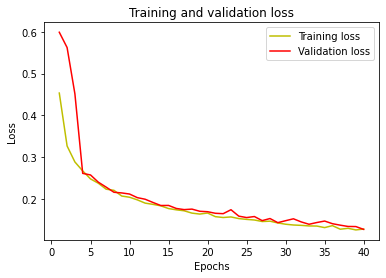

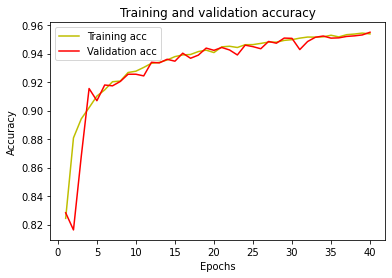

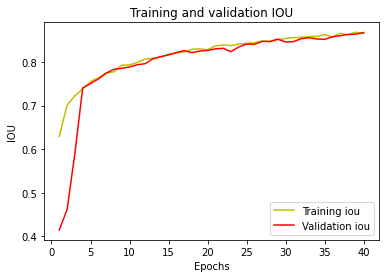

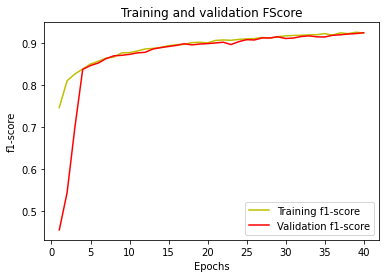

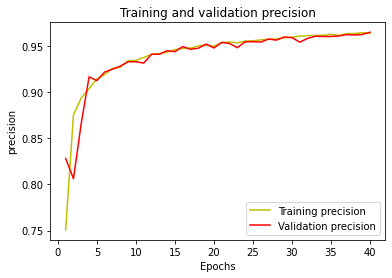

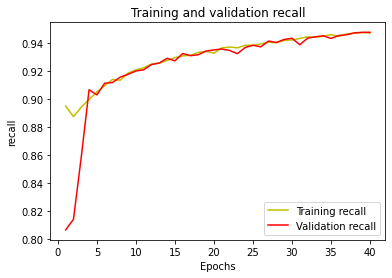

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.plot(epochs, iou, 'y', label='Training iou')
plt.plot(epochs, val_iou, 'r', label='Validation iou')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

fscore = history.history['f1-score']
val_fscore = history.history['val_f1-score']
plt.plot(epochs, fscore, 'y', label='Training f1-score')
plt.plot(epochs, val_fscore, 'r', label='Validation f1-score')
plt.title('Training and validation FScore')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'y', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()


recall = history.history['recall']
val_recall = history.history['val_recall']
plt.plot(epochs, recall, 'y', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()

In [ ]:
# Metrics sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'
loss, IoU, FScore, precision, recall, acc = model.evaluate(X_test, y_test, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("F score is", FScore)
print("IoU is ", IoU)
print("Precision is", precision)
print("Recall is", recall)

Loss is  0.12020700424909592
Accuracy is  0.9595370888710022
F score is 0.9321890473365784
IoU is  0.8761455416679382
Precision is 0.9542132616043091
Recall is 0.9638959765434265


plot ground truth + predicted

(256, 256)


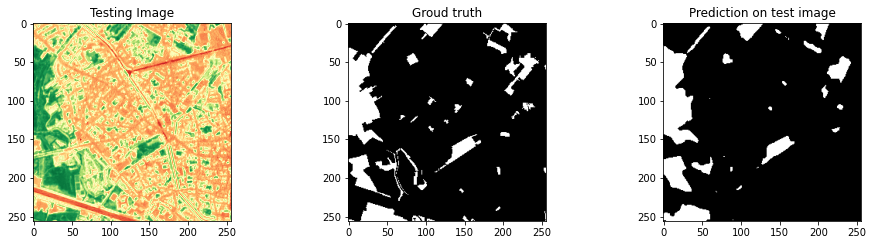

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

print(test_prediction1.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,2], cmap='RdYlGn')

plt.subplot(232)
plt.title('Groud truth')
plt.imshow(ground_truth[:,:,1], cmap='gray')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')

plt.show()

test on Washington and Tel Aviv in next script